In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Предсказываем пол клиента по его банковским транзакциям

In [ ]:
gender_tr=pd.read_csv('/content/drive/MyDrive/ML/datasets/sber_da/gender_train.csv')
tr_codes=pd.read_csv('/content/drive/MyDrive/ML/datasets/sber_da/tr_mcc_codes.csv',sep=';')
tr_types=pd.read_csv('/content/drive/MyDrive/ML/datasets/sber_da/tr_types.csv',sep=';')
ts=pd.read_csv('/content/drive/MyDrive/ML/datasets/sber_da/transactions.csv')

In [ ]:
ts.head()

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id
0,39026145,0 10:23:26,4814,1030,-2245.92,NaN
1,39026145,1 10:19:29,6011,7010,56147.89,NaN
2,39026145,1 10:20:56,4829,2330,-56147.89,NaN
3,39026145,1 10:39:54,5499,1010,-1392.47,NaN
4,39026145,2 15:33:42,5499,1010,-920.83,NaN


In [ ]:
ts=ts.sample(n=1500000,random_state=1)
ts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500000 entries, 2696548 to 2253345
Data columns (total 6 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   customer_id  1500000 non-null  int64  
 1   tr_datetime  1500000 non-null  object 
 2   mcc_code     1500000 non-null  int64  
 3   tr_type      1500000 non-null  int64  
 4   amount       1500000 non-null  float64
 5   term_id      893993 non-null   object 
dtypes: float64(1), int64(3), object(2)
memory usage: 80.1+ MB


In [ ]:
df=pd.merge(ts,gender_tr,on=['customer_id'])
df=pd.merge(df,tr_codes,on=['mcc_code'])
df=pd.merge(df,tr_types,on=['tr_type'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 821689 entries, 0 to 821688
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   customer_id      821689 non-null  int64  
 1   tr_datetime      821689 non-null  object 
 2   mcc_code         821689 non-null  int64  
 3   tr_type          821689 non-null  int64  
 4   amount           821689 non-null  float64
 5   term_id          488504 non-null  object 
 6   gender           821689 non-null  int64  
 7   mcc_description  821689 non-null  object 
 8   tr_description   821689 non-null  object 
dtypes: float64(1), int64(4), object(4)
memory usage: 62.7+ MB


In [ ]:
df.head()

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id,gender,mcc_description,tr_description
0,33842444,433 09:56:51,5999,1010,-1122.96,10183463,1,Плавательные бассейны — распродажа,Покупка. POS ТУ СБ РФ
1,33842444,320 14:22:39,5999,1010,-5165.61,10145267,1,Плавательные бассейны — распродажа,Покупка. POS ТУ СБ РФ
2,33842444,303 13:26:00,5999,1010,-3840.52,10145267,1,Плавательные бассейны — распродажа,Покупка. POS ТУ СБ РФ
3,33842444,389 13:20:29,5999,1010,-5367.74,10183463,1,Плавательные бассейны — распродажа,Покупка. POS ТУ СБ РФ
4,33842444,112 15:53:14,5999,1010,-5727.09,NaN,1,Плавательные бассейны — распродажа,Покупка. POS ТУ СБ РФ


In [ ]:
#можем посмотреть популярные поступления и затраты
df_pos_amount = df[df['amount']>0]
df_neg_amount = df[df['amount']<0]
df_neg_amount['mcc_description'].value_counts().head(10)

Финансовые институты — снятие наличности автоматически                                                                                                        144379
Звонки с использованием телефонов, считывающих магнитную ленту                                                                                                120347
Бакалейные магазины, супермаркеты                                                                                                                             117999
Денежные переводы                                                                                                                                              72612
Различные продовольственные магазины — рынки, магазины со спец-ассортиментом, продажа полуфабрикатов, фирменных блюд, продажа с помощью торговых автоматов     41438
Станции техобслуживания                                                                                                                                        17409
Аптеки    

In [ ]:
#популярные заявления в разрезе пола
df_pos_amount_1 = df_pos_amount[df_pos_amount['gender']==1]
df_pos_amount_0 = df_pos_amount[df_pos_amount['gender']==0]
df_pos_amount_0['mcc_description'].value_counts().head(10)

Финансовые институты — снятие наличности вручную          56902
Финансовые институты — снятие наличности автоматически    18043
Финансовые институты — торговля и услуги                    620
Прямой маркетинг — торговля через каталог                   321
Денежные переводы MasterCard MoneySend                      262
Магазины мужской и женской одежды                            98
Пассажирские железные перевозки                              73
Плавательные бассейны — распродажа                           59
Бакалейные магазины, супермаркеты                            51
Различные магазины одежды и аксессуаров                      46
Name: mcc_description, dtype: int64

In [ ]:
df.drop(['mcc_code','tr_type','term_id'],axis=1,inplace=True)

## Предобработка №1

Будем предсказывать пол клиента по его транзакциям. У нас в датафрейме объект - это транзакции. Необходимо свести их к пользователям.

In [ ]:
amount_group=df.groupby(by='customer_id').agg(
    {
        'amount':['mean','count','median', 'std','sum']
    }
)
amount_group.head()

amount                                             
                      mean count     median            std          sum
customer_id                                                            
22899         22384.065000    54  -2829.855  105856.870474   1208739.51
28753       -206422.034107    56 -51247.980  788529.661705 -11559633.91
42096         -5323.258527   224  -8186.365   68228.896989  -1192409.91
49793        -43673.760435   115  -3553.040  161687.778802  -5022482.45
50940        -13140.211724    29 -11229.580   13972.063220   -381066.14

In [ ]:
#сводная таблица
mcc_pivot=pd.pivot_table(df,index=['customer_id'],columns=['mcc_description'],values='amount',aggfunc=np.mean)
mcc_pivot.head(20)

mcc_description,"Авиалинии, авиакомпании","Авиалинии, авиакомпании, нигде более не классифицированные",Автобусные линии,Автозапчасти и аксессуары,Автоматизированные бензозаправки,Автомойки,Автошины,"Агентства по автотранспортным перевозкам, местные/дальные автогрузоперевозки, компании попереезду и хранению, местная доставка",Агентства по аренде автомобилей,Агенты и менеджеры по аренде недвижимости,...,"Фотостудии, фотолаборатории","Химикалии и смежные вещества, не классифицированные ранее",Химчистки,Ценные бумаги: брокеры/дилеры,Центры здоровья,"Цифровые товары, игры",Школы — бизнес и секретарей,Штрафы,"Штучные товары, галантерея и другие текстильные товары",Электрические части и оборудование
customer_id,,,,,,,,,,,,,,,,,,,,,
22899,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49793,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52926,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70680,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81626,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
mcc_pivot.shape

(8387, 184)

In [ ]:
full_df = amount_group.join(mcc_pivot)
full_df.head()

<ipython-input-25-a67f98c50a42>:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  full_df = amount_group.join(mcc_pivot)


,"(amount, mean)","(amount, count)","(amount, median)","(amount, std)","(amount, sum)","Авиалинии, авиакомпании","Авиалинии, авиакомпании, нигде более не классифицированные",Автобусные линии,Автозапчасти и аксессуары,Автоматизированные бензозаправки,...,"Фотостудии, фотолаборатории","Химикалии и смежные вещества, не классифицированные ранее",Химчистки,Ценные бумаги: брокеры/дилеры,Центры здоровья,"Цифровые товары, игры",Школы — бизнес и секретарей,Штрафы,"Штучные товары, галантерея и другие текстильные товары",Электрические части и оборудование
customer_id,,,,,,,,,,,,,,,,,,,,,
22899,22384.065000,54,-2829.855,105856.870474,1208739.51,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28753,-206422.034107,56,-51247.980,788529.661705,-11559633.91,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42096,-5323.258527,224,-8186.365,68228.896989,-1192409.91,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49793,-43673.760435,115,-3553.040,161687.778802,-5022482.45,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50940,-13140.211724,29,-11229.580,13972.063220,-381066.14,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
gender_tr.index = gender_tr['customer_id']

In [ ]:
#объединяем все таблица - сводную, операции на amount и gender
full_df = full_df.join(gender_tr)
full_df

,"(amount, mean)","(amount, count)","(amount, median)","(amount, std)","(amount, sum)","Авиалинии, авиакомпании","Авиалинии, авиакомпании, нигде более не классифицированные",Автобусные линии,Автозапчасти и аксессуары,Автоматизированные бензозаправки,...,Химчистки,Ценные бумаги: брокеры/дилеры,Центры здоровья,"Цифровые товары, игры",Школы — бизнес и секретарей,Штрафы,"Штучные товары, галантерея и другие текстильные товары",Электрические части и оборудование,customer_id,gender
customer_id,,,,,,,,,,,,,,,,,,,,,
22899,22384.065000,54,-2829.855,105856.870474,1208739.51,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22899,1
28753,-206422.034107,56,-51247.980,788529.661705,-11559633.91,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28753,0
42096,-5323.258527,224,-8186.365,68228.896989,-1192409.91,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42096,0
49793,-43673.760435,115,-3553.040,161687.778802,-5022482.45,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49793,1
50940,-13140.211724,29,-11229.580,13972.063220,-381066.14,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50940,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99917144,-15122.949699,166,-2014.700,65041.219749,-2510409.65,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99917144,0
99967537,-75238.180000,2,-75238.180,100050.447658,-150476.36,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99967537,1
99984336,-118864.867000,10,-8140.320,215875.458281,-1188648.67,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99984336,1


## Строим сеть - предсказываем пол клиента

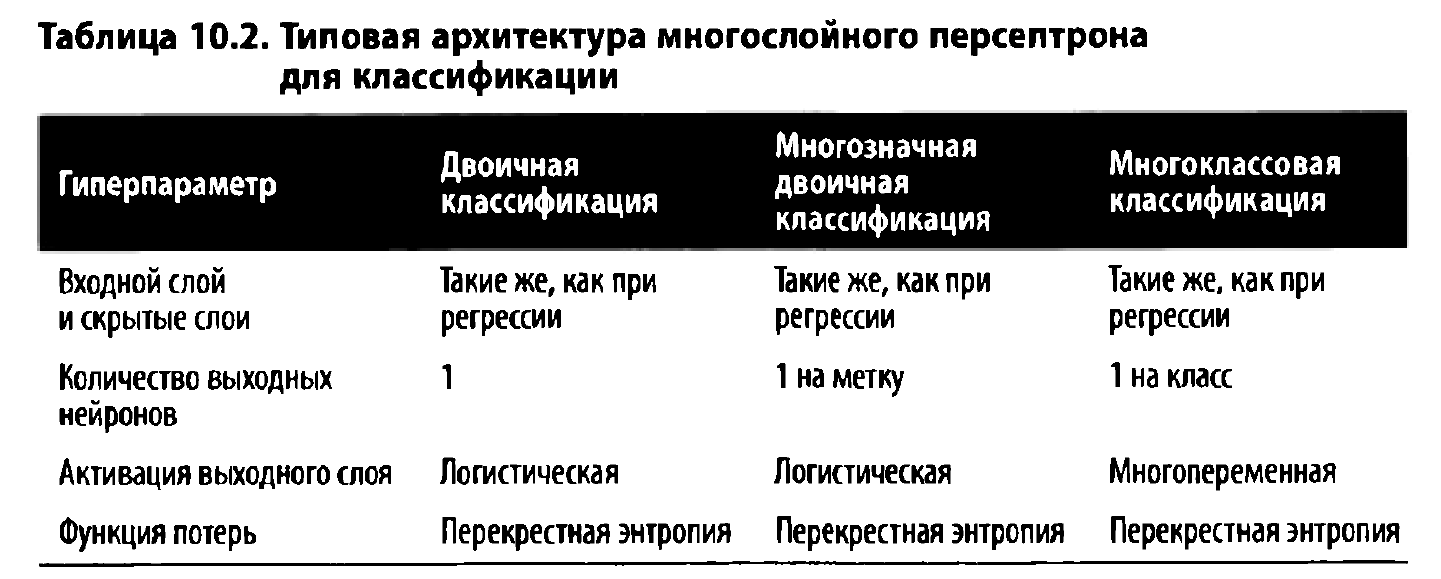

In [ ]:
X=full_df.drop(['gender','customer_id'],axis=1)
y=full_df['gender']
X.fillna(-1, inplace=True)

In [ ]:
#обратите внимание - есть столбцы-кортеж, избавляемся от этого
X.columns=[str(x[0])+' '+str(x[1]) for x in X.columns[:5]]+X.columns[5:].tolist()

In [ ]:
#стандартизировать признаки - для сетки это важно (можете попробовать без стандартизации - будет грустно)
scal_X = StandardScaler().fit_transform(X)
scal_X = pd.DataFrame(scal_X, columns=X.columns)

In [ ]:
#разделение выборок
X_train_full,X_test,y_train_full,y_test = train_test_split(scal_X,y,test_size=0.2,random_state=0)
X_train,X_valid,y_train,y_valid = train_test_split(X_train_full,y_train_full,test_size=0.2,random_state=0)

In [ ]:
model = keras.models.Sequential()

In [ ]:
X_train.shape

(5367, 189)

In [ ]:
opt = keras.optimizers.Adam(learning_rate=1e-06) #ограничиваем скорость обучения - если пустить на самотек, то тоже будет грустно

In [ ]:
model.add(Dense(189, activation='relu', input_dim=189))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.BinaryAccuracy()]) #BinaryAccuracy - метрика точности для бинарной классификации

history=model.fit(X_train, y_train, epochs =100,batch_size=5)

acc=model.evaluate(X_test,y_test)
print(np.array(acc)[1].round(2))

Epoch 1/100
1074/1074 [==============================] - 5s 4ms/step - loss: 0.7096 - binary_accuracy: 0.4962
Epoch 2/100
1074/1074 [==============================] - 3s 3ms/step - loss: 0.7086 - binary_accuracy: 0.5034
Epoch 3/100
1074/1074 [==============================] - 2s 2ms/step - loss: 0.7076 - binary_accuracy: 0.5129
Epoch 4/100
1074/1074 [==============================] - 2s 2ms/step - loss: 0.7066 - binary_accuracy: 0.5182
Epoch 5/100
1074/1074 [==============================] - 2s 2ms/step - loss: 0.7056 - binary_accuracy: 0.5238
Epoch 6/100
1074/1074 [==============================] - 2s 2ms/step - loss: 0.7046 - binary_accuracy: 0.5271
Epoch 7/100
1074/1074 [==============================] - 4s 4ms/step - loss: 0.7037 - binary_accuracy: 0.5323
Epoch 8/100
1074/1074 [==============================] - 3s 2ms/step - loss: 0.7027 - binary_accuracy: 0.5347
Epoch 9/100
1074/1074 [==============================] - 2s 2ms/step - loss: 0.7018 - binary_accuracy: 0.5383
Epoch 10/1

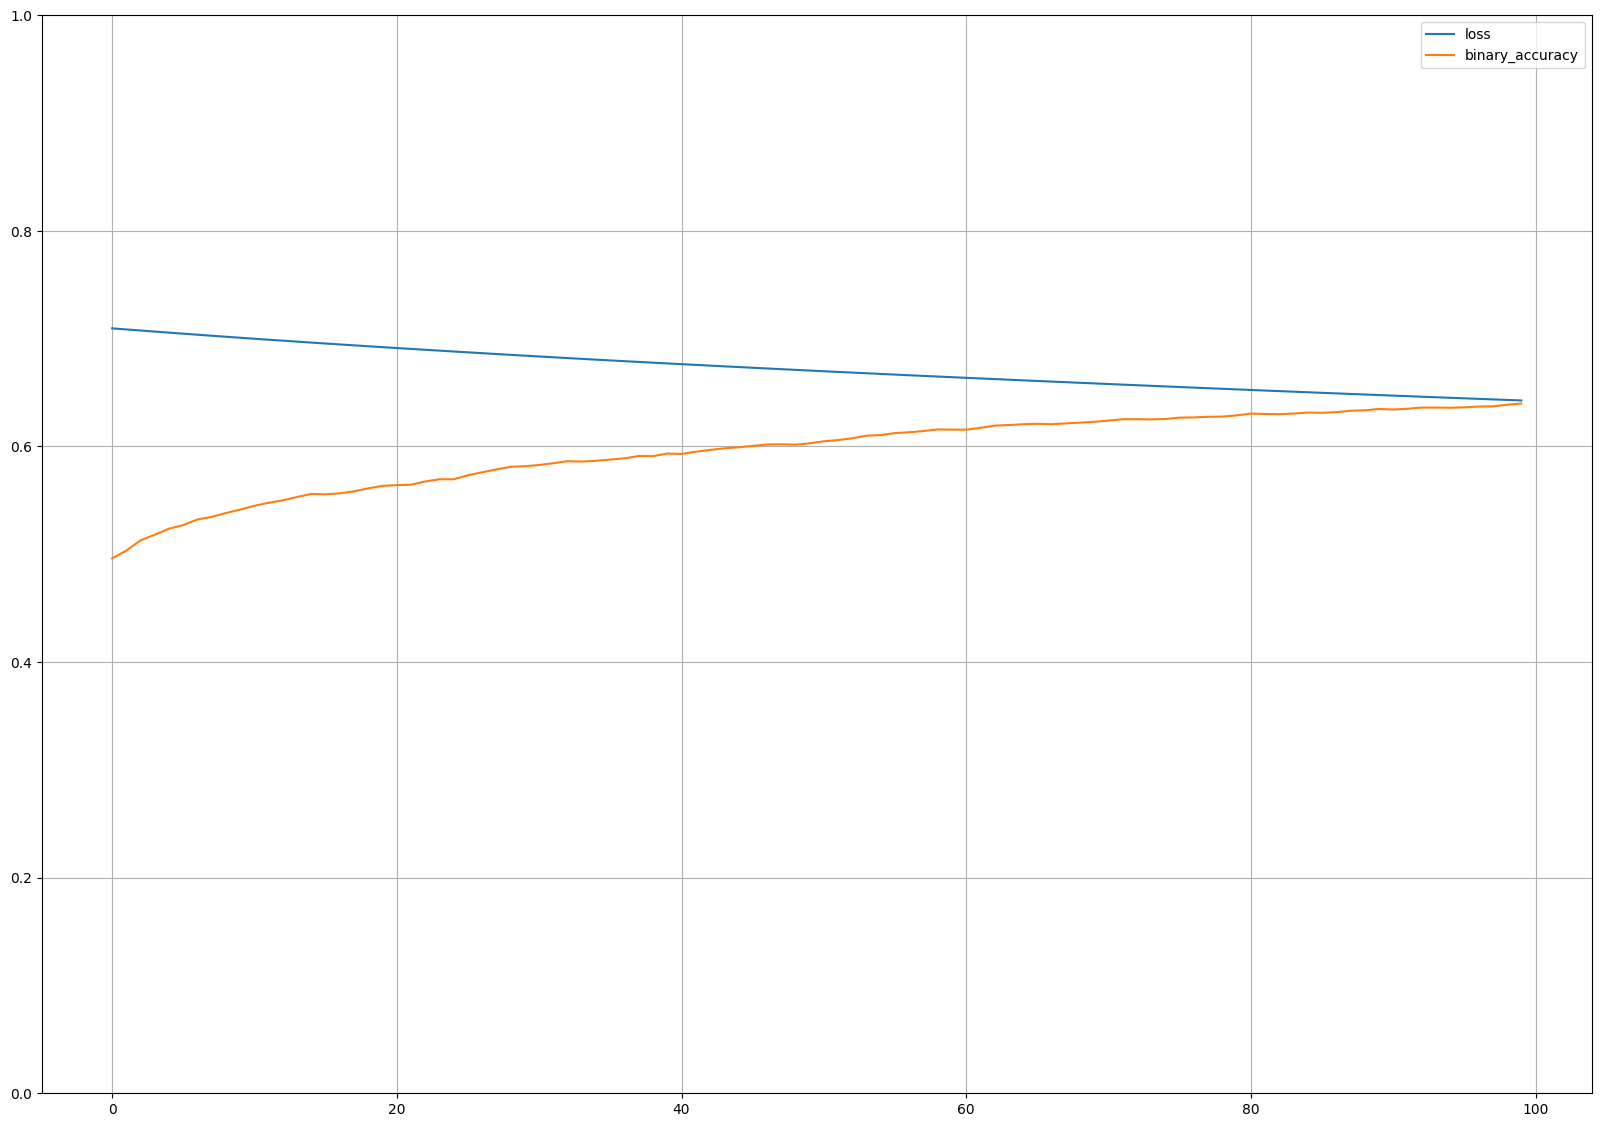

In [ ]:
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(20,14))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
y_pred_nn = model.predict(X_test) > 0.5 #по умолчанию predict возвращает вероятность 1 класса
y_pred_nn[:10]

53/53 [==============================] - 0s 6ms/step


array([[False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [False]])

In [ ]:
#преобразуем bool в метки класса
y_pred_nn = y_pred_nn.reshape(-1)*1
y_pred_nn[:10]

array([0, 0, 0, 0, 0, 1, 0, 1, 1, 0])

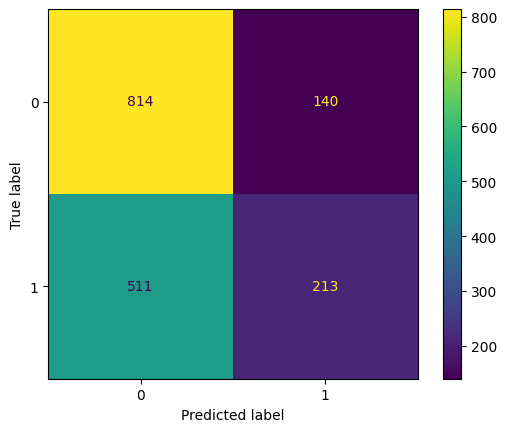

In [ ]:
#матрица путаницы
cm = confusion_matrix(y_test, y_pred_nn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()